# Hierarchical is not worth it. Lower AUC

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from catboost import Pool, CatBoostClassifier, cv
pd.options.display.max_columns
pd.set_option('display.max_columns', None)

# Data Prep

In [47]:
X_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/X_train.csv', index_col='id')
y_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/y_train.csv', squeeze=True)
X_test = pd.read_csv ('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/X_test.csv')
y_test = np.full(len(X_test), np.nan)

In [48]:
df = pd.concat([X_train, X_test])

df = df.drop(['v_screening_date'], axis=1) # duplicate of 'screening_date'
df = df.drop(['v_type_of_assessment'], axis=1) # duplicate of 'type_of_assessment'
df = df.drop(['type_of_assessment'], axis=1) # 0 variance

df['target'] = y_train.to_list() + list(y_test) # set target row-wise (ignoring indices)
# df['target'] = 0

In [50]:
# Engineer a new targets 
df['target_int'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 2}) # so we can do regression
df['target_bool'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 1}) # 0 - no-rec, 1 - rec
target_cols = ['target', 'target_int', 'target_bool']

In [54]:
# Engineer new date based features

"""
Custody: when someone is kept in prison until they go to court
Screening:  involves  using  a  brief  instrument  to  quickly  capture basic information 
    about a person’s risk to reoffend and is  used  to  determine  if  a  more  comprehensive  assessment
    is  warranted.  In  a  jail  setting,  everyone,  regardless  of  legal  status, should be screened 
    at booking.  Risk  screening  divides  the  jail  population  into  high-,  medium-,  and  low-risk 
    categories,  making  it  possible  to  direct  intervention  resources  first  to  the highest-risk individuals.



- c_arrest_date and c_offense_date are mutually exclusive and one of them is 99.8% likely to be filled
- c_arrest_date and c_are mutually exclusive
- start is number of days between c_jail_in and c_jail_out, maybe worth engineering total hours/minutes between
- screening_date is always filled
"""



days_cols = []

def days_between(d1, d2):
    try:
        try:
            d1 = datetime.strptime(d1, "%Y-%m-%d")
        except ValueError:
            d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
            
        try:
            d2 = datetime.strptime(d2, "%Y-%m-%d")
        except ValueError:
            d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
        return abs((d2 - d1).days)
    except TypeError as e:
        return None

# mutually exclusive and one of them is always filled
df['c_bad_date'] = df['c_arrest_date'].fillna(df['c_offense_date']).fillna(df['in_custody']).fillna(df['screening_date'])

# how many days in custody
df['custody_days'] = df.apply(lambda x: days_between(x.out_custody, x.in_custody), axis=1)

# how quickly after going into custody did the person get screened (might indicate something?)
df['in_custody_to_screening_days'] = df.apply(lambda x: days_between(x.in_custody, x.screening_date), axis=1)

# questionable col because it is age related... Also corr=1 with age
df['birth_to_bad_days'] = df.apply(lambda x: days_between(x.date_of_birth, x.c_bad_date), axis=1)

# How many days passed until recitivism occcured. Golden feature!
df['days_until_recitivism'] = df.apply(lambda x: days_between(x.c_jail_out, x.r_jail_in), axis=1)

date_cols = [ 
    'c_arrest_date', 
    'c_offense_date',
    'screening_date', 
    'in_custody', 
    'out_custody', 
    'date_of_birth',
    'c_jail_in',
    'c_jail_out',
    'r_jail_in',
    'r_jail_out',

    # engineered
    'c_bad_date'
]

duration_cols = [
    'days_b_screening_arrest',
    'custody_days',
    'in_custody_to_screening_days',
    'birth_to_bad_days',
    'days_until_recitivism',
]

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,id,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,NaN,No-Recidivism,0.0,0.0,2013-09-23,4.0,1.0,7147,NaN
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,NaN,Violent,2.0,1.0,2013-06-15,0.0,1.0,6713,NaN
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,NaN,Non-Violent,1.0,1.0,2013-10-11,4.0,1.0,10776,66.0
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,NaN,No-Recidivism,0.0,0.0,2014-01-11,1.0,1.0,10236,NaN
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,NaN,No-Recidivism,0.0,0.0,2013-03-21,NaN,NaN,9445,NaN


In [55]:
# All prior counts
df['all_priors'] = df[[
    'juv_fel_count',
    'juv_misd_count', 
    'juv_other_count',
    'priors_count',
]].sum(axis=1)

In [56]:
# Has recidivism occured?
df['has_r_jail_in'] = df['r_jail_in'].notna()
df['has_r_jail_out'] = df['r_jail_out'].notna()

In [57]:
# fill missing values
df['c_charge_desc'] = df['c_charge_desc'].fillna('missing') 

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,id,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism,all_priors,has_r_jail_in,has_r_jail_out
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,NaN,No-Recidivism,0.0,0.0,2013-09-23,4.0,1.0,7147,NaN,2,False,False
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,NaN,Violent,2.0,1.0,2013-06-15,0.0,1.0,6713,NaN,2,False,False
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,NaN,Non-Violent,1.0,1.0,2013-10-11,4.0,1.0,10776,66.0,6,True,True
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,NaN,No-Recidivism,0.0,0.0,2014-01-11,1.0,1.0,10236,NaN,3,False,False
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,NaN,No-Recidivism,0.0,0.0,2013-03-21,NaN,NaN,9445,NaN,2,False,False


In [59]:
cols = [
#     'name', useless
#     'first', useless
#     'last', useless
#     'sex', # 0 importance + potential bias
#     'date_of_birth', date
#     'age', # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'juv_fel_count',
#     'juv_misd_count', 
#     'juv_other_count',
#     'priors_count', 
    'days_b_screening_arrest', # + AOC, - fairness
#     'c_jail_in', date
#     'c_jail_out',date
#     'c_offense_date', date
#     'c_arrest_date', date
#     'c_charge_degree',  # 0 importance
#     'c_charge_desc',
#     'r_jail_in', date
#     'r_jail_out', date
#     'screening_date', date
#     'in_custody', date
#     'out_custody', date
    'start', # + AOC, + fairness
#     'target', target
#     'target_int', target
#     'target_bool', target
#     'c_bad_date', date
    'custody_days', # + AOC, + fairness
    'in_custody_to_screening_days', # + AOC, + fairness
#     'birth_to_bad_days', # corr=1 with age
#     'has_r_jail_in', + AOC, - fairness
#     'has_r_jail_out', # corr=1 with r_jail_in
    'days_until_recitivism', # golden feature!
    'all_priors', # good
]

cat_cols = [
#     'sex',  # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'c_charge_degree', # 0 importance
#     'c_charge_desc',
]

In [60]:
df[cols].isna().sum()/len(df[cols])

days_b_screening_arrest         0.056504
start                           0.000000
custody_days                    0.044065
in_custody_to_screening_days    0.044065
days_until_recitivism           0.855577
all_priors                      0.000000
dtype: float64

<AxesSubplot:>

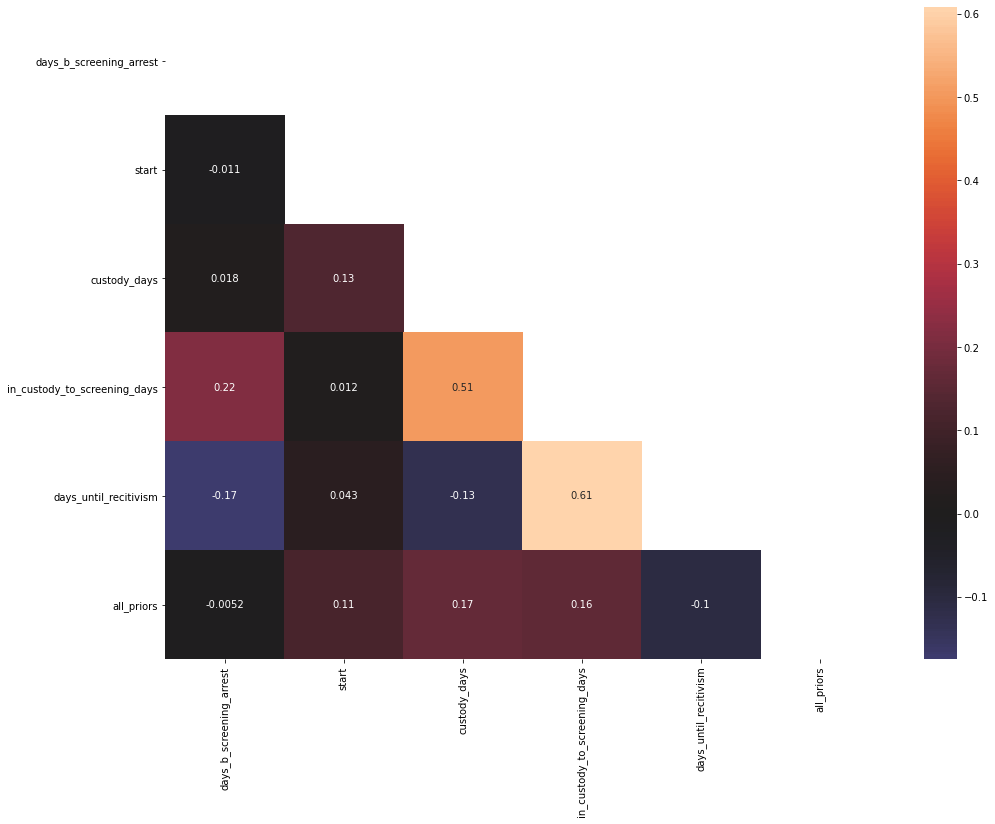

In [61]:
# Numeric correlations across numeric features
f, ax = plt.subplots(figsize=(16, 12))
corr = df[cols].corr()
mask = np.triu(corr)
sns.heatmap(corr.select_dtypes('number'), annot=True, center=0, mask=mask)

In [62]:
df[cols].head()

,days_b_screening_arrest,start,custody_days,in_custody_to_screening_days,days_until_recitivism,all_priors
2677,-1.0,3,4.0,1.0,NaN,2
548,-1.0,0,0.0,1.0,NaN,2
4483,-1.0,3,4.0,1.0,66.0,6
9476,-1.0,0,1.0,1.0,NaN,3
199,NaN,0,NaN,NaN,NaN,2


In [63]:
# df['race'] = df['race'].replace({'Native American': 'Other'})
# df['race'] = df['race'].replace({'Native American': 'Other', 'Asian': 'Other'})
df['race'] = df['race'].replace({'Native American': 'Other', 'Asian': 'Other', 'Hispanic': 'Other'})
df['race'].value_counts()

African-American    2266
Caucasian           1701
Other                776
Name: race, dtype: int64

In [64]:
races = df.race.unique()
sexes = df.sex.unique()
age_groups = df.age_group.unique()

# Cross Validation

In [65]:
df[cols] = df[cols].fillna(0)

In [66]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

def fairness_score(y_true, y_pred, sensitive_features):
    mf = MetricFrame(roc_auc_score, y_true, y_pred, sensitive_features=sensitive_features)
    return (1 - np.sqrt(np.std(mf.by_group)))

In [77]:
df_train = df[df.target.notna()]

df_test = df[df.target.isna()]

# Multi-class Classification
Non-recidivism / Non-Violent / Violent

In [71]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race'] + df_train['sex'] + df_train['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df.iloc[train].reset_index(drop=True)
    df_eval_cv = df.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=df_train_cv[cols],
                         label=df_train_cv[TARGET_COL],
                         cat_features=cat_cols)

    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv[TARGET_COL],
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(df_eval_cv[TARGET_COL]).to_numpy()
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='MultiClass')
    # Fit model
    model.fit(train_dataset, verbose=False)
    # Get predicted classes
#     preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')
    
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

Split  1: ROC-AUC: 89.64%. Fairness: R: 84.53%, S: 77.92%, A: 82.21%
Split  2: ROC-AUC: 85.69%. Fairness: R: 84.55%, S: 87.30%, A: 79.78%
Split  3: ROC-AUC: 87.54%. Fairness: R: 76.29%, S: 89.36%, A: 84.17%
Split  4: ROC-AUC: 88.65%. Fairness: R: 76.88%, S: 93.02%, A: 84.34%
Split  5: ROC-AUC: 86.14%. Fairness: R: 83.32%, S: 82.49%, A: 70.88%
Split  6: ROC-AUC: 87.20%. Fairness: R: 83.23%, S: 85.23%, A: 90.35%
Split  7: ROC-AUC: 89.24%. Fairness: R: 81.82%, S: 85.94%, A: 84.15%
Split  8: ROC-AUC: 85.77%. Fairness: R: 84.26%, S: 88.15%, A: 87.44%
Split  9: ROC-AUC: 90.80%. Fairness: R: 86.29%, S: 77.11%, A: 78.23%
Split 10: ROC-AUC: 87.45%. Fairness: R: 77.19%, S: 91.85%, A: 72.18%
Split 11: ROC-AUC: 84.98%. Fairness: R: 84.02%, S: 85.64%, A: 81.53%
Split 12: ROC-AUC: 84.58%. Fairness: R: 75.15%, S: 83.99%, A: 74.00%
Split 13: ROC-AUC: 91.33%. Fairness: R: 84.39%, S: 83.17%, A: 82.34%
Split 14: ROC-AUC: 88.77%. Fairness: R: 76.77%, S: 88.40%, A: 91.22%
Split 15: ROC-AUC: 90.58%. Fairnes

In [72]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

ROC-AUC 88.15% (STD: 2.06%)
Race fairness: 82.66% (STD: 4.51%)
Sex fairness: 84.48% (STD: 5.16%)
Age fairness: 82.86% (STD: 5.30%)


# Hierarchical Classification

### Level 1: Non-recidivism / Recidivism

In [92]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target_bool'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race'] + df_train['sex'] + df_train['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df_train.iloc[train].reset_index(drop=True)
    df_eval_cv = df_train.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=df_train_cv[cols],
                         label=df_train_cv[TARGET_COL],
                         cat_features=cat_cols)

    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv[TARGET_COL],
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(df_eval_cv[TARGET_COL]).to_numpy()
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss')
    # Fit model
    model.fit(train_dataset, verbose=False)
    # Get predicted classes
#     preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')
    
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

Split  1: ROC-AUC: 90.20%. Fairness: R: 82.05%, S: 85.76%, A: 81.10%
Split  2: ROC-AUC: 91.25%. Fairness: R: 83.29%, S: 78.58%, A: 93.17%
Split  3: ROC-AUC: 94.47%. Fairness: R: 81.01%, S: 90.59%, A: 89.17%
Split  4: ROC-AUC: 90.15%. Fairness: R: 80.28%, S: 82.92%, A: 83.62%
Split  5: ROC-AUC: 91.13%. Fairness: R: 79.01%, S: 88.39%, A: 86.08%
Split  6: ROC-AUC: 90.41%. Fairness: R: 83.55%, S: 86.35%, A: 88.16%
Split  7: ROC-AUC: 89.92%. Fairness: R: 92.26%, S: 79.40%, A: 77.71%
Split  8: ROC-AUC: 92.58%. Fairness: R: 80.59%, S: 90.27%, A: 81.82%
Split  9: ROC-AUC: 91.66%. Fairness: R: 87.75%, S: 80.97%, A: 83.86%
Split 10: ROC-AUC: 92.55%. Fairness: R: 83.80%, S: 83.32%, A: 85.65%
Split 11: ROC-AUC: 91.00%. Fairness: R: 74.92%, S: 86.03%, A: 85.50%
Split 12: ROC-AUC: 94.25%. Fairness: R: 90.57%, S: 88.19%, A: 84.24%
Split 13: ROC-AUC: 88.98%. Fairness: R: 84.77%, S: 77.39%, A: 83.97%
Split 14: ROC-AUC: 92.66%. Fairness: R: 84.90%, S: 91.76%, A: 86.25%
Split 15: ROC-AUC: 88.25%. Fairnes

In [93]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

ROC-AUC 91.38% (STD: 1.53%)
Race fairness: 84.73% (STD: 4.26%)
Sex fairness: 86.73% (STD: 4.66%)
Age fairness: 85.54% (STD: 4.05%)


,feature,importance,std,min,max
4,days_until_recitivism,49.167113,11.048733,34.647485,66.911300
5,all_priors,17.929176,3.029078,11.372065,25.059451
3,in_custody_to_screening_days,10.863223,3.947136,3.894650,20.332997
2,custody_days,9.775010,3.945380,4.378151,18.175114
1,start,7.111016,2.367807,2.826109,12.277413
0,days_b_screening_arrest,5.154462,2.212519,1.260367,10.506137


<AxesSubplot:ylabel='feature'>

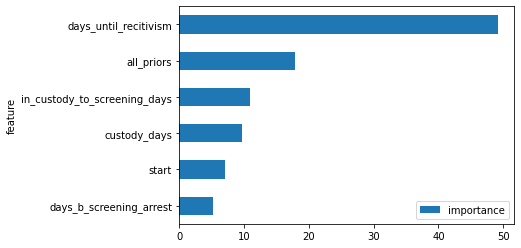

In [94]:
# Feature importances
fi_df = pd.DataFrame({'feature': cols})
fi_df['importance'] = np.mean(feature_importances, axis=0)
fi_df['std'] = np.std(feature_importances, axis=0)
fi_df['min'] = np.min(feature_importances, axis=0)
fi_df['max'] = np.max(feature_importances, axis=0)
fi_df = fi_df.sort_values('importance', ascending=False)
display(fi_df)
display(fi_df[['feature', 'importance']].sort_values('importance', ascending=True).plot.barh(x='feature'))

### Level 2 (Violent vs Non-Violent)

In [90]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train_recid[TARGET_COL].astype('str') + df_train_recid['race'] + df_train_recid['sex'] + df_train_recid['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train_recid[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df_train_recid.iloc[train].reset_index(drop=True)
    df_eval_cv = df_train_recid.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=df_train_cv[cols],
                         label=df_train_cv[TARGET_COL],
                         cat_features=cat_cols)

    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv[TARGET_COL],
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(df_eval_cv[TARGET_COL]).to_numpy()
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss')
    # Fit model
    model.fit(train_dataset, verbose=False)
    # Get predicted classes
#     preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')
    
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

Split  1: ROC-AUC: 90.85%. Fairness: R: 77.71%, S: 93.47%, A: 79.04%
Split  2: ROC-AUC: 88.72%. Fairness: R: 81.55%, S: 77.61%, A: 74.89%
Split  3: ROC-AUC: 90.12%. Fairness: R: 65.90%, S: 94.10%, A: 86.95%
Split  4: ROC-AUC: 92.80%. Fairness: R: 91.59%, S: 85.54%, A: 77.11%
Split  5: ROC-AUC: 92.52%. Fairness: R: 86.24%, S: 87.96%, A: 85.87%
Split  6: ROC-AUC: 91.34%. Fairness: R: 80.43%, S: 91.44%, A: 88.44%
Split  7: ROC-AUC: 85.86%. Fairness: R: 74.20%, S: 80.29%, A: 77.94%
Split  8: ROC-AUC: 93.06%. Fairness: R: 75.80%, S: 82.91%, A: 79.25%
Split  9: ROC-AUC: 87.20%. Fairness: R: 82.35%, S: 90.46%, A: 68.28%
Split 10: ROC-AUC: 90.76%. Fairness: R: 72.30%, S: 95.58%, A: 68.41%
Split 11: ROC-AUC: 90.31%. Fairness: R: 87.07%, S: 89.90%, A: 76.82%
Split 12: ROC-AUC: 89.60%. Fairness: R: 81.39%, S: 87.98%, A: 86.88%
Split 13: ROC-AUC: 90.36%. Fairness: R: 85.33%, S: 81.39%, A: 85.91%
Split 14: ROC-AUC: 90.29%. Fairness: R: 78.29%, S: 71.48%, A: 93.15%
Split 15: ROC-AUC: 92.26%. Fairnes

In [91]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

ROC-AUC 90.46% (STD: 2.19%)
Race fairness: 80.83% (STD: 6.29%)
Sex fairness: 85.94% (STD: 6.58%)
Age fairness: 80.31% (STD: 6.89%)


,feature,importance,std,min,max
4,days_until_recitivism,49.186384,3.746608,39.615267,56.641203
3,in_custody_to_screening_days,19.298630,2.965336,13.253630,26.609652
2,custody_days,10.798012,2.039679,6.035135,15.115522
5,all_priors,9.137618,1.603606,5.002269,14.384285
1,start,6.265355,1.826179,2.555942,11.650008
0,days_b_screening_arrest,5.314001,1.377750,2.716259,8.937487


<AxesSubplot:ylabel='feature'>

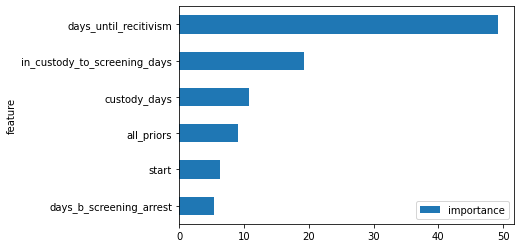

In [84]:
# Feature importances
fi_df = pd.DataFrame({'feature': cols})
fi_df['importance'] = np.mean(feature_importances, axis=0)
fi_df['std'] = np.std(feature_importances, axis=0)
fi_df['min'] = np.min(feature_importances, axis=0)
fi_df['max'] = np.max(feature_importances, axis=0)
fi_df = fi_df.sort_values('importance', ascending=False)
display(fi_df)
display(fi_df[['feature', 'importance']].sort_values('importance', ascending=True).plot.barh(x='feature'))

### Both levels (L1+L2)

In [113]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race'] + df_train['sex'] + df_train['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df_train.iloc[train].reset_index(drop=True)
    df_train_cv_recid = df_train_cv[df_train_cv['target'] != 'No-Recidivism']
    df_eval_cv = df_train.iloc[test].reset_index(drop=True)
    
    train_dataset_l1 = Pool(data=df_train_cv[cols],
                         label=df_train_cv['target_bool'],
                         cat_features=cat_cols)
    
    train_dataset_l2 = Pool(data=df_train_cv_recid[cols],
                         label=df_train_cv_recid['target'],
                         cat_features=cat_cols)
    
    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv['target'],
                        cat_features=cat_cols)
    

    y_eval = pd.get_dummies(df_eval_cv['target']).to_numpy()
    # Initialize CatBoostClassifier
    model_l1 = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss')
    
    model_l2 = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss')
    # Fit model
    model_l1.fit(train_dataset_l1, verbose=False)
    model_l2.fit(train_dataset_l2, verbose=False)
    
    # Get predicted classes
    preds_class_l1 = model_l1.predict(eval_dataset)
    preds_class_l2 = model_l2.predict(eval_dataset)
#     # Get predicted probabilities for each class
    preds_proba_l1 = model_l1.predict_proba(eval_dataset)
    preds_proba_l2 = model_l2.predict_proba(eval_dataset)
    
    preds_class = [(l2 if l1 == 1 else 'No-Recidivism') for l1, l2 in zip(preds_class_l1, preds_class_l2)]
    preds_proba = [(l1[0], l1[1]*l2[0], l1[1]*l2[1]) for l1, l2 in zip(preds_proba_l1, preds_proba_l2)]
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

Split  1: ROC-AUC: 89.80%. Fairness: R: 80.64%, S: 77.96%, A: 78.90%
Split  2: ROC-AUC: 86.68%. Fairness: R: 83.22%, S: 83.83%, A: 77.74%
Split  3: ROC-AUC: 87.90%. Fairness: R: 79.44%, S: 93.01%, A: 85.20%
Split  4: ROC-AUC: 88.69%. Fairness: R: 80.31%, S: 97.40%, A: 80.67%
Split  5: ROC-AUC: 87.98%. Fairness: R: 87.93%, S: 80.36%, A: 76.17%
Split  6: ROC-AUC: 86.43%. Fairness: R: 85.12%, S: 82.89%, A: 86.75%
Split  7: ROC-AUC: 86.46%. Fairness: R: 76.06%, S: 82.57%, A: 94.70%
Split  8: ROC-AUC: 85.61%. Fairness: R: 83.20%, S: 94.34%, A: 88.10%
Split  9: ROC-AUC: 89.38%. Fairness: R: 82.20%, S: 75.31%, A: 74.30%
Split 10: ROC-AUC: 85.41%. Fairness: R: 77.43%, S: 93.15%, A: 74.93%
Split 11: ROC-AUC: 84.51%. Fairness: R: 81.51%, S: 86.91%, A: 86.22%
Split 12: ROC-AUC: 85.93%. Fairness: R: 74.57%, S: 78.85%, A: 73.37%
Split 13: ROC-AUC: 91.71%. Fairness: R: 83.03%, S: 81.91%, A: 85.78%
Split 14: ROC-AUC: 88.17%. Fairness: R: 80.72%, S: 77.24%, A: 81.23%
Split 15: ROC-AUC: 87.89%. Fairnes

In [114]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

ROC-AUC 87.99% (STD: 1.92%)
Race fairness: 81.93% (STD: 3.87%)
Sex fairness: 85.46% (STD: 6.02%)
Age fairness: 82.03% (STD: 4.68%)


## Fairlearn GridSearch
Non-recidivism / Recidivism

In [20]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame, equalized_odds_difference
from fairlearn.reductions import GridSearch, EqualizedOdds

TARGET_COL = 'target_bool'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race'] + df_train['sex'] + df_train['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

# feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], df['race'])): # Stratified on race
    df_train_cv = df_train.iloc[train].reset_index(drop=True)
    eval_df = df_train.iloc[test].reset_index(drop=True)
    
#     y_eval = pd.get_dummies(eval_df[TARGET_COL]).to_numpy()
    y_eval = eval_df[TARGET_COL]
    
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss', 
                               logging_level='Silent')
    
    sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=64,
                   grid_limit=3)
    
    sweep.fit(df_train_cv[cols], df_train_cv[TARGET_COL], sensitive_features=df_train_cv['race'])

    sweep_pred_probas = [predictor.predict_proba(eval_df[cols])[:, 1] for predictor in sweep.predictors_]
#     sweep_preds = [predictor.predict(eval_df[cols]) for predictor in sweep.predictors_] 
    sweep_fairnesses = [
        fairness_score(eval_df[TARGET_COL], preds, sensitive_features=eval_df['race'])
        for preds in sweep_pred_probas
    ]
    sweep_aucs = [
        roc_auc_score(eval_df[TARGET_COL], preds)
        for preds in sweep_pred_probas
    ]

    all_results = pd.DataFrame({"predictor": sweep.predictors_, "fairness": sweep_fairnesses, "auc": sweep_aucs}) 
    all_results['score'] = (all_results['fairness'] + all_results['auc']) / 2
    all_results = all_results.sort_values('score', ascending=False)
    top_models_idx = all_results.iloc[:5].index
    top_sweep_pred_probas = [probs for idx, probs in enumerate(sweep_pred_probas) if idx in top_models_idx]
    preds_proba = np.mean(top_sweep_pred_probas, axis=0)
    
    display(all_results.sort_values('score', ascending=False))

    #     Fit model
#     model.fit(X=df_train_cv[cols], y=df_train_cv[TARGET_COL], cat_features=cat_cols, verbose=0)
    # Get predicted classes
#     preds_class = model.predict(eval_df[cols])
#     # Get predicted probabilities for each class
#     preds_proba = model.predict_proba(eval_df[cols])
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_df[cols], 
#                               prediction_type='RawFormulaVal')
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=eval_df['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=eval_df['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=eval_df['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
            
    roc_aucs.append(roc_auc)
#     feature_importances.append(model.get_feature_importance())
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

,predictor,fairness,auc,score
58,<catboost.core.CatBoostClassifier object at 0x...,0.838211,0.873484,0.855847
20,<catboost.core.CatBoostClassifier object at 0x...,0.861478,0.850185,0.855831
56,<catboost.core.CatBoostClassifier object at 0x...,0.880093,0.822853,0.851473
54,<catboost.core.CatBoostClassifier object at 0x...,0.827888,0.868592,0.848240
57,<catboost.core.CatBoostClassifier object at 0x...,0.817906,0.870751,0.844329
...,...,...,...,...
33,<catboost.core.CatBoostClassifier object at 0x...,0.823072,0.550123,0.686598
48,<catboost.core.CatBoostClassifier object at 0x...,0.803515,0.554506,0.679011
43,<catboost.core.CatBoostClassifier object at 0x...,0.763193,0.583784,0.673488
39,<catboost.core.CatBoostClassifier object at 0x...,0.715323,0.620360,0.667842


Split  1: ROC-AUC: 88.12%. Fairness: R: 85.66%, S: 89.62%, A: 85.88%


,predictor,fairness,auc,score
25,<catboost.core.CatBoostClassifier object at 0x...,0.885709,0.829807,0.857758
24,<catboost.core.CatBoostClassifier object at 0x...,0.884028,0.825310,0.854669
19,<catboost.core.CatBoostClassifier object at 0x...,0.860358,0.847682,0.854020
33,<catboost.core.CatBoostClassifier object at 0x...,0.813031,0.888849,0.850940
11,<catboost.core.CatBoostClassifier object at 0x...,0.789042,0.910949,0.849995
...,...,...,...,...
41,<catboost.core.CatBoostClassifier object at 0x...,0.730844,0.706388,0.718616
14,<catboost.core.CatBoostClassifier object at 0x...,0.841605,0.588234,0.714920
2,<catboost.core.CatBoostClassifier object at 0x...,0.755813,0.662930,0.709372
34,<catboost.core.CatBoostClassifier object at 0x...,0.733105,0.680122,0.706613


Split  2: ROC-AUC: 91.07%. Fairness: R: 78.27%, S: 85.74%, A: 90.96%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.902221,0.940407,0.921314
45,<catboost.core.CatBoostClassifier object at 0x...,0.865356,0.941582,0.903469
8,<catboost.core.CatBoostClassifier object at 0x...,0.858091,0.938246,0.898168
33,<catboost.core.CatBoostClassifier object at 0x...,0.843490,0.937172,0.890331
11,<catboost.core.CatBoostClassifier object at 0x...,0.834461,0.936500,0.885481
...,...,...,...,...
31,<catboost.core.CatBoostClassifier object at 0x...,0.768902,0.697591,0.733247
2,<catboost.core.CatBoostClassifier object at 0x...,0.819612,0.641963,0.730787
54,<catboost.core.CatBoostClassifier object at 0x...,0.742481,0.698582,0.720532
55,<catboost.core.CatBoostClassifier object at 0x...,0.724242,0.700690,0.712466


Split  3: ROC-AUC: 94.49%. Fairness: R: 85.41%, S: 93.33%, A: 89.25%


,predictor,fairness,auc,score
33,<catboost.core.CatBoostClassifier object at 0x...,0.867958,0.891540,0.879749
50,<catboost.core.CatBoostClassifier object at 0x...,0.922760,0.821443,0.872102
45,<catboost.core.CatBoostClassifier object at 0x...,0.844692,0.896886,0.870789
36,<catboost.core.CatBoostClassifier object at 0x...,0.858054,0.882087,0.870070
49,<catboost.core.CatBoostClassifier object at 0x...,0.940737,0.796561,0.868649
...,...,...,...,...
17,<catboost.core.CatBoostClassifier object at 0x...,0.720790,0.618869,0.669829
2,<catboost.core.CatBoostClassifier object at 0x...,0.773666,0.563095,0.668381
14,<catboost.core.CatBoostClassifier object at 0x...,0.730261,0.571817,0.651039
27,<catboost.core.CatBoostClassifier object at 0x...,0.701401,0.579646,0.640524


Split  4: ROC-AUC: 88.76%. Fairness: R: 85.57%, S: 77.47%, A: 85.96%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.844788,0.930019,0.887403
45,<catboost.core.CatBoostClassifier object at 0x...,0.843792,0.929774,0.886783
8,<catboost.core.CatBoostClassifier object at 0x...,0.833967,0.926676,0.880321
36,<catboost.core.CatBoostClassifier object at 0x...,0.822291,0.930286,0.876288
10,<catboost.core.CatBoostClassifier object at 0x...,0.837388,0.909261,0.873325
...,...,...,...,...
16,<catboost.core.CatBoostClassifier object at 0x...,0.695786,0.644573,0.670180
55,<catboost.core.CatBoostClassifier object at 0x...,0.708804,0.622992,0.665898
52,<catboost.core.CatBoostClassifier object at 0x...,0.679555,0.628870,0.654212
27,<catboost.core.CatBoostClassifier object at 0x...,0.642592,0.624714,0.633653


Split  5: ROC-AUC: 94.50%. Fairness: R: 86.71%, S: 81.87%, A: 90.36%


,predictor,fairness,auc,score
10,<catboost.core.CatBoostClassifier object at 0x...,0.908452,0.871673,0.890062
63,<catboost.core.CatBoostClassifier object at 0x...,0.876830,0.876556,0.876693
36,<catboost.core.CatBoostClassifier object at 0x...,0.840484,0.904545,0.872514
45,<catboost.core.CatBoostClassifier object at 0x...,0.833295,0.906618,0.869956
33,<catboost.core.CatBoostClassifier object at 0x...,0.835643,0.902283,0.868963
...,...,...,...,...
14,<catboost.core.CatBoostClassifier object at 0x...,0.800803,0.618405,0.709604
39,<catboost.core.CatBoostClassifier object at 0x...,0.746571,0.665585,0.706078
54,<catboost.core.CatBoostClassifier object at 0x...,0.730983,0.664775,0.697879
52,<catboost.core.CatBoostClassifier object at 0x...,0.731579,0.658579,0.695079


Split  6: ROC-AUC: 90.97%. Fairness: R: 84.07%, S: 84.91%, A: 81.93%


,predictor,fairness,auc,score
33,<catboost.core.CatBoostClassifier object at 0x...,0.907573,0.896644,0.902109
45,<catboost.core.CatBoostClassifier object at 0x...,0.894810,0.893673,0.894242
36,<catboost.core.CatBoostClassifier object at 0x...,0.894634,0.883807,0.889221
8,<catboost.core.CatBoostClassifier object at 0x...,0.875289,0.894534,0.884912
51,<catboost.core.CatBoostClassifier object at 0x...,0.959403,0.792055,0.875729
...,...,...,...,...
16,<catboost.core.CatBoostClassifier object at 0x...,0.753086,0.568116,0.660601
2,<catboost.core.CatBoostClassifier object at 0x...,0.721202,0.578709,0.649955
14,<catboost.core.CatBoostClassifier object at 0x...,0.738191,0.550878,0.644535
17,<catboost.core.CatBoostClassifier object at 0x...,0.711184,0.570614,0.640899


Split  7: ROC-AUC: 89.98%. Fairness: R: 93.18%, S: 83.76%, A: 84.38%


,predictor,fairness,auc,score
57,<catboost.core.CatBoostClassifier object at 0x...,0.824413,0.905237,0.864825
58,<catboost.core.CatBoostClassifier object at 0x...,0.823807,0.897365,0.860586
59,<catboost.core.CatBoostClassifier object at 0x...,0.827939,0.893169,0.860554
60,<catboost.core.CatBoostClassifier object at 0x...,0.828578,0.882506,0.855542
55,<catboost.core.CatBoostClassifier object at 0x...,0.809201,0.894427,0.851814
...,...,...,...,...
37,<catboost.core.CatBoostClassifier object at 0x...,0.779980,0.672460,0.726220
42,<catboost.core.CatBoostClassifier object at 0x...,0.750277,0.693438,0.721857
35,<catboost.core.CatBoostClassifier object at 0x...,0.837748,0.601124,0.719436
33,<catboost.core.CatBoostClassifier object at 0x...,0.753081,0.675857,0.714469


Split  8: ROC-AUC: 89.91%. Fairness: R: 82.49%, S: 80.81%, A: 80.32%


,predictor,fairness,auc,score
8,<catboost.core.CatBoostClassifier object at 0x...,0.881722,0.947131,0.914426
45,<catboost.core.CatBoostClassifier object at 0x...,0.886730,0.942117,0.914424
11,<catboost.core.CatBoostClassifier object at 0x...,0.878335,0.939404,0.908869
56,<catboost.core.CatBoostClassifier object at 0x...,0.903080,0.913006,0.908043
36,<catboost.core.CatBoostClassifier object at 0x...,0.866796,0.922251,0.894523
...,...,...,...,...
52,<catboost.core.CatBoostClassifier object at 0x...,0.860843,0.635559,0.748201
16,<catboost.core.CatBoostClassifier object at 0x...,0.790431,0.683509,0.736970
39,<catboost.core.CatBoostClassifier object at 0x...,0.794873,0.659365,0.727119
2,<catboost.core.CatBoostClassifier object at 0x...,0.796528,0.633947,0.715238


Split  9: ROC-AUC: 94.64%. Fairness: R: 89.60%, S: 84.92%, A: 87.32%


,predictor,fairness,auc,score
45,<catboost.core.CatBoostClassifier object at 0x...,0.898314,0.909478,0.903896
11,<catboost.core.CatBoostClassifier object at 0x...,0.864810,0.909955,0.887382
8,<catboost.core.CatBoostClassifier object at 0x...,0.859224,0.906488,0.882856
33,<catboost.core.CatBoostClassifier object at 0x...,0.846782,0.900153,0.873467
36,<catboost.core.CatBoostClassifier object at 0x...,0.838339,0.898086,0.868213
...,...,...,...,...
39,<catboost.core.CatBoostClassifier object at 0x...,0.779606,0.618158,0.698882
16,<catboost.core.CatBoostClassifier object at 0x...,0.738745,0.656121,0.697433
52,<catboost.core.CatBoostClassifier object at 0x...,0.774737,0.617132,0.695935
2,<catboost.core.CatBoostClassifier object at 0x...,0.699619,0.632258,0.665938


Split 10: ROC-AUC: 90.52%. Fairness: R: 86.71%, S: 87.75%, A: 81.20%


,predictor,fairness,auc,score
45,<catboost.core.CatBoostClassifier object at 0x...,0.878931,0.914030,0.896480
36,<catboost.core.CatBoostClassifier object at 0x...,0.867484,0.902294,0.884889
11,<catboost.core.CatBoostClassifier object at 0x...,0.836143,0.927947,0.882045
8,<catboost.core.CatBoostClassifier object at 0x...,0.849278,0.905691,0.877485
33,<catboost.core.CatBoostClassifier object at 0x...,0.831445,0.905246,0.868346
...,...,...,...,...
16,<catboost.core.CatBoostClassifier object at 0x...,0.744265,0.639302,0.691784
30,<catboost.core.CatBoostClassifier object at 0x...,0.695037,0.674623,0.684830
17,<catboost.core.CatBoostClassifier object at 0x...,0.761708,0.602850,0.682279
2,<catboost.core.CatBoostClassifier object at 0x...,0.772011,0.585375,0.678693


Split 11: ROC-AUC: 91.47%. Fairness: R: 84.74%, S: 83.92%, A: 92.82%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.905150,0.917870,0.911510
11,<catboost.core.CatBoostClassifier object at 0x...,0.886010,0.920333,0.903172
33,<catboost.core.CatBoostClassifier object at 0x...,0.889577,0.913825,0.901701
45,<catboost.core.CatBoostClassifier object at 0x...,0.862254,0.929591,0.895922
63,<catboost.core.CatBoostClassifier object at 0x...,0.898170,0.871489,0.884830
...,...,...,...,...
31,<catboost.core.CatBoostClassifier object at 0x...,0.751026,0.698915,0.724970
28,<catboost.core.CatBoostClassifier object at 0x...,0.726914,0.720301,0.723608
16,<catboost.core.CatBoostClassifier object at 0x...,0.748856,0.694384,0.721620
2,<catboost.core.CatBoostClassifier object at 0x...,0.788932,0.640210,0.714571


Split 12: ROC-AUC: 92.66%. Fairness: R: 87.86%, S: 83.15%, A: 89.29%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.859071,0.924474,0.891772
25,<catboost.core.CatBoostClassifier object at 0x...,0.926157,0.821752,0.873954
45,<catboost.core.CatBoostClassifier object at 0x...,0.835744,0.910555,0.873150
50,<catboost.core.CatBoostClassifier object at 0x...,0.881859,0.844104,0.862981
19,<catboost.core.CatBoostClassifier object at 0x...,0.882945,0.835914,0.859430
...,...,...,...,...
2,<catboost.core.CatBoostClassifier object at 0x...,0.735861,0.578709,0.657285
14,<catboost.core.CatBoostClassifier object at 0x...,0.819615,0.494868,0.657241
27,<catboost.core.CatBoostClassifier object at 0x...,0.753891,0.546455,0.650173
52,<catboost.core.CatBoostClassifier object at 0x...,0.751858,0.525122,0.638490


Split 13: ROC-AUC: 92.34%. Fairness: R: 83.30%, S: 92.35%, A: 86.03%


,predictor,fairness,auc,score
8,<catboost.core.CatBoostClassifier object at 0x...,0.843690,0.902583,0.873137
28,<catboost.core.CatBoostClassifier object at 0x...,0.960559,0.776555,0.868557
44,<catboost.core.CatBoostClassifier object at 0x...,0.897024,0.813857,0.855441
50,<catboost.core.CatBoostClassifier object at 0x...,0.880496,0.829502,0.854999
19,<catboost.core.CatBoostClassifier object at 0x...,0.848874,0.853878,0.851376
...,...,...,...,...
39,<catboost.core.CatBoostClassifier object at 0x...,0.747578,0.668385,0.707981
27,<catboost.core.CatBoostClassifier object at 0x...,0.771457,0.635486,0.703472
17,<catboost.core.CatBoostClassifier object at 0x...,0.698243,0.696769,0.697506
52,<catboost.core.CatBoostClassifier object at 0x...,0.713717,0.675100,0.694408


Split 14: ROC-AUC: 90.70%. Fairness: R: 87.52%, S: 86.71%, A: 83.95%


,predictor,fairness,auc,score
8,<catboost.core.CatBoostClassifier object at 0x...,0.852455,0.896962,0.874708
36,<catboost.core.CatBoostClassifier object at 0x...,0.845772,0.897304,0.871538
11,<catboost.core.CatBoostClassifier object at 0x...,0.817747,0.903927,0.860837
33,<catboost.core.CatBoostClassifier object at 0x...,0.829893,0.889233,0.859563
45,<catboost.core.CatBoostClassifier object at 0x...,0.813809,0.896344,0.855076
...,...,...,...,...
18,<catboost.core.CatBoostClassifier object at 0x...,0.666518,0.722778,0.694648
17,<catboost.core.CatBoostClassifier object at 0x...,0.801093,0.580663,0.690878
2,<catboost.core.CatBoostClassifier object at 0x...,0.786212,0.564248,0.675230
27,<catboost.core.CatBoostClassifier object at 0x...,0.750027,0.564910,0.657469


Split 15: ROC-AUC: 89.73%. Fairness: R: 83.35%, S: 86.45%, A: 81.58%


,predictor,fairness,auc,score
60,<catboost.core.CatBoostClassifier object at 0x...,0.869294,0.887735,0.878514
55,<catboost.core.CatBoostClassifier object at 0x...,0.847699,0.887950,0.867825
57,<catboost.core.CatBoostClassifier object at 0x...,0.818107,0.910397,0.864252
59,<catboost.core.CatBoostClassifier object at 0x...,0.827644,0.899113,0.863378
20,<catboost.core.CatBoostClassifier object at 0x...,0.825357,0.894011,0.859684
...,...,...,...,...
51,<catboost.core.CatBoostClassifier object at 0x...,0.781653,0.607000,0.694327
43,<catboost.core.CatBoostClassifier object at 0x...,0.778089,0.609791,0.693940
48,<catboost.core.CatBoostClassifier object at 0x...,0.746304,0.626482,0.686393
34,<catboost.core.CatBoostClassifier object at 0x...,0.726370,0.642231,0.684301


Split 16: ROC-AUC: 90.24%. Fairness: R: 82.41%, S: 87.95%, A: 77.27%


,predictor,fairness,auc,score
12,<catboost.core.CatBoostClassifier object at 0x...,0.903615,0.895478,0.899547
32,<catboost.core.CatBoostClassifier object at 0x...,0.917233,0.870321,0.893777
29,<catboost.core.CatBoostClassifier object at 0x...,0.906745,0.873185,0.889965
11,<catboost.core.CatBoostClassifier object at 0x...,0.850303,0.926771,0.888537
7,<catboost.core.CatBoostClassifier object at 0x...,0.894194,0.876780,0.885487
...,...,...,...,...
17,<catboost.core.CatBoostClassifier object at 0x...,0.722746,0.684245,0.703496
39,<catboost.core.CatBoostClassifier object at 0x...,0.702745,0.691839,0.697292
16,<catboost.core.CatBoostClassifier object at 0x...,0.700072,0.680521,0.690296
42,<catboost.core.CatBoostClassifier object at 0x...,0.644079,0.712799,0.678439


Split 17: ROC-AUC: 89.38%. Fairness: R: 90.20%, S: 90.97%, A: 83.60%


,predictor,fairness,auc,score
33,<catboost.core.CatBoostClassifier object at 0x...,0.873929,0.904319,0.889124
36,<catboost.core.CatBoostClassifier object at 0x...,0.873742,0.900604,0.887173
8,<catboost.core.CatBoostClassifier object at 0x...,0.820857,0.913119,0.866988
45,<catboost.core.CatBoostClassifier object at 0x...,0.820030,0.908006,0.864018
11,<catboost.core.CatBoostClassifier object at 0x...,0.819325,0.899428,0.859377
...,...,...,...,...
5,<catboost.core.CatBoostClassifier object at 0x...,0.742598,0.620483,0.681540
55,<catboost.core.CatBoostClassifier object at 0x...,0.756969,0.602581,0.679775
52,<catboost.core.CatBoostClassifier object at 0x...,0.755237,0.590944,0.673091
27,<catboost.core.CatBoostClassifier object at 0x...,0.742227,0.538550,0.640388


Split 18: ROC-AUC: 91.10%. Fairness: R: 84.35%, S: 85.43%, A: 77.78%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.804112,0.912730,0.858421
11,<catboost.core.CatBoostClassifier object at 0x...,0.804088,0.907113,0.855600
45,<catboost.core.CatBoostClassifier object at 0x...,0.801603,0.908637,0.855120
33,<catboost.core.CatBoostClassifier object at 0x...,0.795948,0.910062,0.853005
8,<catboost.core.CatBoostClassifier object at 0x...,0.795376,0.905622,0.850499
...,...,...,...,...
16,<catboost.core.CatBoostClassifier object at 0x...,0.744062,0.661910,0.702986
17,<catboost.core.CatBoostClassifier object at 0x...,0.762682,0.635394,0.699038
2,<catboost.core.CatBoostClassifier object at 0x...,0.776769,0.591869,0.684319
27,<catboost.core.CatBoostClassifier object at 0x...,0.744732,0.620910,0.682821


Split 19: ROC-AUC: 91.08%. Fairness: R: 79.76%, S: 79.82%, A: 86.86%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.925440,0.919732,0.922586
45,<catboost.core.CatBoostClassifier object at 0x...,0.907306,0.919596,0.913451
8,<catboost.core.CatBoostClassifier object at 0x...,0.878079,0.915833,0.896956
36,<catboost.core.CatBoostClassifier object at 0x...,0.882943,0.904665,0.893804
33,<catboost.core.CatBoostClassifier object at 0x...,0.856225,0.904115,0.880170
...,...,...,...,...
52,<catboost.core.CatBoostClassifier object at 0x...,0.774413,0.645006,0.709709
17,<catboost.core.CatBoostClassifier object at 0x...,0.787409,0.613933,0.700671
2,<catboost.core.CatBoostClassifier object at 0x...,0.736096,0.624605,0.680351
14,<catboost.core.CatBoostClassifier object at 0x...,0.766462,0.573991,0.670227


Split 20: ROC-AUC: 91.78%. Fairness: R: 88.69%, S: 86.75%, A: 74.89%


,predictor,fairness,auc,score
7,<catboost.core.CatBoostClassifier object at 0x...,0.929907,0.833624,0.881765
11,<catboost.core.CatBoostClassifier object at 0x...,0.828482,0.894819,0.861651
0,<catboost.core.CatBoostClassifier object at 0x...,0.878755,0.838319,0.858537
1,<catboost.core.CatBoostClassifier object at 0x...,0.842126,0.867561,0.854843
45,<catboost.core.CatBoostClassifier object at 0x...,0.812325,0.895759,0.854042
...,...,...,...,...
31,<catboost.core.CatBoostClassifier object at 0x...,0.788827,0.697751,0.743289
34,<catboost.core.CatBoostClassifier object at 0x...,0.715814,0.754388,0.735101
27,<catboost.core.CatBoostClassifier object at 0x...,0.753645,0.707466,0.730555
14,<catboost.core.CatBoostClassifier object at 0x...,0.752267,0.691574,0.721921


Split 21: ROC-AUC: 86.94%. Fairness: R: 83.67%, S: 81.28%, A: 88.12%


,predictor,fairness,auc,score
58,<catboost.core.CatBoostClassifier object at 0x...,0.882119,0.924046,0.903082
57,<catboost.core.CatBoostClassifier object at 0x...,0.871786,0.927869,0.899827
16,<catboost.core.CatBoostClassifier object at 0x...,0.879757,0.841451,0.860604
20,<catboost.core.CatBoostClassifier object at 0x...,0.824661,0.896276,0.860468
53,<catboost.core.CatBoostClassifier object at 0x...,0.792272,0.909875,0.851073
...,...,...,...,...
33,<catboost.core.CatBoostClassifier object at 0x...,0.736698,0.625146,0.680922
51,<catboost.core.CatBoostClassifier object at 0x...,0.718403,0.612130,0.665267
48,<catboost.core.CatBoostClassifier object at 0x...,0.673167,0.622329,0.647748
43,<catboost.core.CatBoostClassifier object at 0x...,0.727429,0.566850,0.647140


Split 22: ROC-AUC: 92.39%. Fairness: R: 86.89%, S: 81.45%, A: 92.21%


,predictor,fairness,auc,score
45,<catboost.core.CatBoostClassifier object at 0x...,0.802404,0.913105,0.857754
46,<catboost.core.CatBoostClassifier object at 0x...,0.842905,0.853375,0.848140
4,<catboost.core.CatBoostClassifier object at 0x...,0.869070,0.824442,0.846756
8,<catboost.core.CatBoostClassifier object at 0x...,0.785173,0.907977,0.846575
33,<catboost.core.CatBoostClassifier object at 0x...,0.789627,0.902530,0.846078
...,...,...,...,...
5,<catboost.core.CatBoostClassifier object at 0x...,0.755733,0.673931,0.714832
34,<catboost.core.CatBoostClassifier object at 0x...,0.697914,0.714018,0.705966
27,<catboost.core.CatBoostClassifier object at 0x...,0.836149,0.556766,0.696458
6,<catboost.core.CatBoostClassifier object at 0x...,0.699212,0.683572,0.691392


Split 23: ROC-AUC: 91.33%. Fairness: R: 81.38%, S: 95.76%, A: 89.95%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.850904,0.904575,0.877740
63,<catboost.core.CatBoostClassifier object at 0x...,0.861164,0.863370,0.862267
33,<catboost.core.CatBoostClassifier object at 0x...,0.812932,0.891389,0.852160
45,<catboost.core.CatBoostClassifier object at 0x...,0.794487,0.903679,0.849083
8,<catboost.core.CatBoostClassifier object at 0x...,0.786052,0.902762,0.844407
...,...,...,...,...
39,<catboost.core.CatBoostClassifier object at 0x...,0.800840,0.592285,0.696563
53,<catboost.core.CatBoostClassifier object at 0x...,0.768654,0.621656,0.695155
2,<catboost.core.CatBoostClassifier object at 0x...,0.847108,0.533915,0.690511
17,<catboost.core.CatBoostClassifier object at 0x...,0.760223,0.594193,0.677208


Split 24: ROC-AUC: 90.54%. Fairness: R: 80.41%, S: 94.47%, A: 83.57%


,predictor,fairness,auc,score
45,<catboost.core.CatBoostClassifier object at 0x...,0.901965,0.937674,0.919819
11,<catboost.core.CatBoostClassifier object at 0x...,0.895288,0.931782,0.913535
36,<catboost.core.CatBoostClassifier object at 0x...,0.893766,0.926920,0.910343
8,<catboost.core.CatBoostClassifier object at 0x...,0.834325,0.931953,0.883139
63,<catboost.core.CatBoostClassifier object at 0x...,0.866452,0.877252,0.871852
...,...,...,...,...
27,<catboost.core.CatBoostClassifier object at 0x...,0.861405,0.579314,0.720360
14,<catboost.core.CatBoostClassifier object at 0x...,0.884641,0.553933,0.719287
55,<catboost.core.CatBoostClassifier object at 0x...,0.779576,0.638375,0.708975
54,<catboost.core.CatBoostClassifier object at 0x...,0.772416,0.636260,0.704338


Split 25: ROC-AUC: 93.94%. Fairness: R: 91.14%, S: 93.56%, A: 83.31%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.881790,0.942190,0.911990
19,<catboost.core.CatBoostClassifier object at 0x...,0.959971,0.861370,0.910671
33,<catboost.core.CatBoostClassifier object at 0x...,0.902541,0.911666,0.907103
36,<catboost.core.CatBoostClassifier object at 0x...,0.866869,0.917069,0.891969
8,<catboost.core.CatBoostClassifier object at 0x...,0.860301,0.923150,0.891726
...,...,...,...,...
17,<catboost.core.CatBoostClassifier object at 0x...,0.806124,0.545362,0.675743
52,<catboost.core.CatBoostClassifier object at 0x...,0.779371,0.570331,0.674851
16,<catboost.core.CatBoostClassifier object at 0x...,0.740353,0.564381,0.652367
27,<catboost.core.CatBoostClassifier object at 0x...,0.762670,0.506440,0.634555


Split 26: ROC-AUC: 93.06%. Fairness: R: 88.97%, S: 79.65%, A: 84.50%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.912947,0.910347,0.911647
8,<catboost.core.CatBoostClassifier object at 0x...,0.888536,0.913542,0.901039
36,<catboost.core.CatBoostClassifier object at 0x...,0.888277,0.908263,0.898270
33,<catboost.core.CatBoostClassifier object at 0x...,0.894079,0.900563,0.897321
45,<catboost.core.CatBoostClassifier object at 0x...,0.865959,0.917314,0.891637
...,...,...,...,...
27,<catboost.core.CatBoostClassifier object at 0x...,0.785437,0.621155,0.703296
2,<catboost.core.CatBoostClassifier object at 0x...,0.776782,0.626301,0.701542
39,<catboost.core.CatBoostClassifier object at 0x...,0.714357,0.667916,0.691136
52,<catboost.core.CatBoostClassifier object at 0x...,0.743171,0.624525,0.683848


Split 27: ROC-AUC: 91.90%. Fairness: R: 89.97%, S: 85.65%, A: 85.73%


,predictor,fairness,auc,score
58,<catboost.core.CatBoostClassifier object at 0x...,0.863230,0.893553,0.878391
57,<catboost.core.CatBoostClassifier object at 0x...,0.845596,0.884881,0.865238
1,<catboost.core.CatBoostClassifier object at 0x...,0.851654,0.870301,0.860977
52,<catboost.core.CatBoostClassifier object at 0x...,0.827718,0.893953,0.860835
53,<catboost.core.CatBoostClassifier object at 0x...,0.829338,0.888904,0.859121
...,...,...,...,...
48,<catboost.core.CatBoostClassifier object at 0x...,0.809123,0.623818,0.716470
44,<catboost.core.CatBoostClassifier object at 0x...,0.747741,0.681670,0.714705
50,<catboost.core.CatBoostClassifier object at 0x...,0.719545,0.702558,0.711052
51,<catboost.core.CatBoostClassifier object at 0x...,0.780638,0.610744,0.695691


Split 28: ROC-AUC: 89.56%. Fairness: R: 84.94%, S: 90.92%, A: 74.50%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.882687,0.910928,0.896808
33,<catboost.core.CatBoostClassifier object at 0x...,0.875835,0.906822,0.891328
8,<catboost.core.CatBoostClassifier object at 0x...,0.867510,0.911527,0.889519
45,<catboost.core.CatBoostClassifier object at 0x...,0.863987,0.906479,0.885233
37,<catboost.core.CatBoostClassifier object at 0x...,0.921372,0.831131,0.876251
...,...,...,...,...
15,<catboost.core.CatBoostClassifier object at 0x...,0.753941,0.689221,0.721581
17,<catboost.core.CatBoostClassifier object at 0x...,0.813917,0.627059,0.720488
27,<catboost.core.CatBoostClassifier object at 0x...,0.791904,0.636834,0.714369
2,<catboost.core.CatBoostClassifier object at 0x...,0.801528,0.611221,0.706375


Split 29: ROC-AUC: 91.14%. Fairness: R: 86.76%, S: 96.46%, A: 86.00%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.857693,0.928107,0.892900
36,<catboost.core.CatBoostClassifier object at 0x...,0.833518,0.924373,0.878945
8,<catboost.core.CatBoostClassifier object at 0x...,0.829749,0.926561,0.878155
45,<catboost.core.CatBoostClassifier object at 0x...,0.809778,0.924908,0.867343
63,<catboost.core.CatBoostClassifier object at 0x...,0.829833,0.899829,0.864831
...,...,...,...,...
55,<catboost.core.CatBoostClassifier object at 0x...,0.728786,0.633702,0.681244
39,<catboost.core.CatBoostClassifier object at 0x...,0.710525,0.649248,0.679887
27,<catboost.core.CatBoostClassifier object at 0x...,0.740377,0.602696,0.671537
14,<catboost.core.CatBoostClassifier object at 0x...,0.714329,0.586690,0.650510


Split 30: ROC-AUC: 93.06%. Fairness: R: 86.12%, S: 91.06%, A: 86.93%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.811787,0.918895,0.865341
45,<catboost.core.CatBoostClassifier object at 0x...,0.797504,0.931842,0.864673
33,<catboost.core.CatBoostClassifier object at 0x...,0.803370,0.925659,0.864514
8,<catboost.core.CatBoostClassifier object at 0x...,0.792578,0.922801,0.857689
11,<catboost.core.CatBoostClassifier object at 0x...,0.779750,0.915615,0.847683
...,...,...,...,...
54,<catboost.core.CatBoostClassifier object at 0x...,0.682495,0.677028,0.679762
55,<catboost.core.CatBoostClassifier object at 0x...,0.697585,0.657632,0.677609
2,<catboost.core.CatBoostClassifier object at 0x...,0.698874,0.650918,0.674896
52,<catboost.core.CatBoostClassifier object at 0x...,0.682199,0.625639,0.653919


Split 31: ROC-AUC: 92.82%. Fairness: R: 80.84%, S: 93.04%, A: 83.40%


,predictor,fairness,auc,score
63,<catboost.core.CatBoostClassifier object at 0x...,0.837095,0.909622,0.873358
11,<catboost.core.CatBoostClassifier object at 0x...,0.818255,0.923416,0.870836
33,<catboost.core.CatBoostClassifier object at 0x...,0.831062,0.896138,0.863600
10,<catboost.core.CatBoostClassifier object at 0x...,0.830764,0.893380,0.862072
50,<catboost.core.CatBoostClassifier object at 0x...,0.885131,0.826343,0.855737
...,...,...,...,...
27,<catboost.core.CatBoostClassifier object at 0x...,0.769991,0.611695,0.690843
22,<catboost.core.CatBoostClassifier object at 0x...,0.690890,0.688608,0.689749
52,<catboost.core.CatBoostClassifier object at 0x...,0.711362,0.649148,0.680255
55,<catboost.core.CatBoostClassifier object at 0x...,0.683742,0.675980,0.679861


Split 32: ROC-AUC: 91.35%. Fairness: R: 84.05%, S: 82.08%, A: 90.38%


,predictor,fairness,auc,score
52,<catboost.core.CatBoostClassifier object at 0x...,0.891395,0.891193,0.891294
58,<catboost.core.CatBoostClassifier object at 0x...,0.852050,0.911303,0.881677
55,<catboost.core.CatBoostClassifier object at 0x...,0.856853,0.898465,0.877659
53,<catboost.core.CatBoostClassifier object at 0x...,0.844796,0.907873,0.876335
54,<catboost.core.CatBoostClassifier object at 0x...,0.856883,0.894986,0.875934
...,...,...,...,...
51,<catboost.core.CatBoostClassifier object at 0x...,0.749693,0.585586,0.667640
38,<catboost.core.CatBoostClassifier object at 0x...,0.710589,0.599784,0.655187
44,<catboost.core.CatBoostClassifier object at 0x...,0.695248,0.586941,0.641094
48,<catboost.core.CatBoostClassifier object at 0x...,0.649699,0.589417,0.619558


Split 33: ROC-AUC: 90.52%. Fairness: R: 86.51%, S: 90.87%, A: 79.84%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.896072,0.888057,0.892064
33,<catboost.core.CatBoostClassifier object at 0x...,0.852825,0.882711,0.867768
45,<catboost.core.CatBoostClassifier object at 0x...,0.829026,0.903577,0.866301
11,<catboost.core.CatBoostClassifier object at 0x...,0.806734,0.912939,0.859836
8,<catboost.core.CatBoostClassifier object at 0x...,0.815103,0.894110,0.854607
...,...,...,...,...
14,<catboost.core.CatBoostClassifier object at 0x...,0.848899,0.598941,0.723920
16,<catboost.core.CatBoostClassifier object at 0x...,0.779849,0.660985,0.720417
34,<catboost.core.CatBoostClassifier object at 0x...,0.725912,0.709184,0.717548
17,<catboost.core.CatBoostClassifier object at 0x...,0.742353,0.692092,0.717223


Split 34: ROC-AUC: 89.96%. Fairness: R: 85.96%, S: 85.37%, A: 85.78%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.919783,0.918648,0.919216
8,<catboost.core.CatBoostClassifier object at 0x...,0.894524,0.916907,0.905716
45,<catboost.core.CatBoostClassifier object at 0x...,0.890400,0.917282,0.903841
10,<catboost.core.CatBoostClassifier object at 0x...,0.922792,0.882343,0.902567
33,<catboost.core.CatBoostClassifier object at 0x...,0.870091,0.905652,0.887871
...,...,...,...,...
15,<catboost.core.CatBoostClassifier object at 0x...,0.768182,0.654623,0.711403
34,<catboost.core.CatBoostClassifier object at 0x...,0.756602,0.660686,0.708644
27,<catboost.core.CatBoostClassifier object at 0x...,0.800428,0.580924,0.690676
14,<catboost.core.CatBoostClassifier object at 0x...,0.792685,0.576398,0.684541


Split 35: ROC-AUC: 92.01%. Fairness: R: 90.01%, S: 97.10%, A: 79.52%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.843291,0.920671,0.881981
45,<catboost.core.CatBoostClassifier object at 0x...,0.833180,0.928915,0.881048
33,<catboost.core.CatBoostClassifier object at 0x...,0.836132,0.918110,0.877121
11,<catboost.core.CatBoostClassifier object at 0x...,0.824119,0.917855,0.870987
8,<catboost.core.CatBoostClassifier object at 0x...,0.810687,0.923457,0.867072
...,...,...,...,...
27,<catboost.core.CatBoostClassifier object at 0x...,0.823096,0.565958,0.694527
16,<catboost.core.CatBoostClassifier object at 0x...,0.753285,0.633731,0.693508
2,<catboost.core.CatBoostClassifier object at 0x...,0.811476,0.559749,0.685612
52,<catboost.core.CatBoostClassifier object at 0x...,0.727336,0.631762,0.679549


Split 36: ROC-AUC: 92.89%. Fairness: R: 83.26%, S: 96.36%, A: 94.61%


,predictor,fairness,auc,score
53,<catboost.core.CatBoostClassifier object at 0x...,0.933767,0.914743,0.924255
60,<catboost.core.CatBoostClassifier object at 0x...,0.939948,0.901146,0.920547
54,<catboost.core.CatBoostClassifier object at 0x...,0.915668,0.910029,0.912849
52,<catboost.core.CatBoostClassifier object at 0x...,0.902093,0.908363,0.905228
55,<catboost.core.CatBoostClassifier object at 0x...,0.891279,0.910558,0.900918
...,...,...,...,...
33,<catboost.core.CatBoostClassifier object at 0x...,0.672442,0.635495,0.653969
50,<catboost.core.CatBoostClassifier object at 0x...,0.666132,0.639015,0.652573
43,<catboost.core.CatBoostClassifier object at 0x...,0.695279,0.600073,0.647676
35,<catboost.core.CatBoostClassifier object at 0x...,0.706065,0.584688,0.645376


Split 37: ROC-AUC: 91.27%. Fairness: R: 90.52%, S: 84.30%, A: 91.30%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.851569,0.906939,0.879254
8,<catboost.core.CatBoostClassifier object at 0x...,0.833572,0.922513,0.878042
45,<catboost.core.CatBoostClassifier object at 0x...,0.839757,0.916314,0.878036
63,<catboost.core.CatBoostClassifier object at 0x...,0.865838,0.889535,0.877687
56,<catboost.core.CatBoostClassifier object at 0x...,0.836599,0.906687,0.871643
...,...,...,...,...
54,<catboost.core.CatBoostClassifier object at 0x...,0.762198,0.710422,0.736310
52,<catboost.core.CatBoostClassifier object at 0x...,0.775890,0.686331,0.731111
27,<catboost.core.CatBoostClassifier object at 0x...,0.786359,0.665107,0.725733
14,<catboost.core.CatBoostClassifier object at 0x...,0.767673,0.660304,0.713988


Split 38: ROC-AUC: 92.31%. Fairness: R: 84.68%, S: 93.08%, A: 85.97%


,predictor,fairness,auc,score
33,<catboost.core.CatBoostClassifier object at 0x...,0.889625,0.889126,0.889376
36,<catboost.core.CatBoostClassifier object at 0x...,0.885139,0.876189,0.880664
45,<catboost.core.CatBoostClassifier object at 0x...,0.842841,0.892000,0.867421
8,<catboost.core.CatBoostClassifier object at 0x...,0.815939,0.884753,0.850346
49,<catboost.core.CatBoostClassifier object at 0x...,0.886893,0.801376,0.844135
...,...,...,...,...
55,<catboost.core.CatBoostClassifier object at 0x...,0.721026,0.590387,0.655706
2,<catboost.core.CatBoostClassifier object at 0x...,0.742633,0.551101,0.646867
39,<catboost.core.CatBoostClassifier object at 0x...,0.673429,0.576048,0.624738
14,<catboost.core.CatBoostClassifier object at 0x...,0.709394,0.539911,0.624653


Split 39: ROC-AUC: 89.20%. Fairness: R: 85.75%, S: 78.25%, A: 87.67%


,predictor,fairness,auc,score
36,<catboost.core.CatBoostClassifier object at 0x...,0.901061,0.905995,0.903528
8,<catboost.core.CatBoostClassifier object at 0x...,0.865052,0.912179,0.888616
45,<catboost.core.CatBoostClassifier object at 0x...,0.862606,0.912264,0.887435
33,<catboost.core.CatBoostClassifier object at 0x...,0.870033,0.900739,0.885386
11,<catboost.core.CatBoostClassifier object at 0x...,0.842808,0.898010,0.870409
...,...,...,...,...
22,<catboost.core.CatBoostClassifier object at 0x...,0.723470,0.650953,0.687212
14,<catboost.core.CatBoostClassifier object at 0x...,0.821188,0.535175,0.678181
27,<catboost.core.CatBoostClassifier object at 0x...,0.783596,0.552704,0.668150
17,<catboost.core.CatBoostClassifier object at 0x...,0.750473,0.556223,0.653348


Split 40: ROC-AUC: 91.07%. Fairness: R: 88.24%, S: 89.58%, A: 77.37%


,predictor,fairness,auc,score
63,<catboost.core.CatBoostClassifier object at 0x...,0.926705,0.850967,0.888836
11,<catboost.core.CatBoostClassifier object at 0x...,0.854777,0.894891,0.874834
44,<catboost.core.CatBoostClassifier object at 0x...,0.916294,0.801241,0.858768
10,<catboost.core.CatBoostClassifier object at 0x...,0.857909,0.830551,0.844230
25,<catboost.core.CatBoostClassifier object at 0x...,0.901877,0.781218,0.841548
...,...,...,...,...
16,<catboost.core.CatBoostClassifier object at 0x...,0.743372,0.670091,0.706732
52,<catboost.core.CatBoostClassifier object at 0x...,0.732063,0.680650,0.706357
14,<catboost.core.CatBoostClassifier object at 0x...,0.765060,0.617663,0.691362
27,<catboost.core.CatBoostClassifier object at 0x...,0.712303,0.615420,0.663861


Split 41: ROC-AUC: 87.97%. Fairness: R: 86.11%, S: 79.37%, A: 85.91%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.847378,0.931022,0.889200
45,<catboost.core.CatBoostClassifier object at 0x...,0.834907,0.924481,0.879694
1,<catboost.core.CatBoostClassifier object at 0x...,0.847483,0.906820,0.877151
36,<catboost.core.CatBoostClassifier object at 0x...,0.829143,0.920841,0.874992
20,<catboost.core.CatBoostClassifier object at 0x...,0.838860,0.905666,0.872263
...,...,...,...,...
54,<catboost.core.CatBoostClassifier object at 0x...,0.763190,0.681281,0.722236
17,<catboost.core.CatBoostClassifier object at 0x...,0.791848,0.650241,0.721044
52,<catboost.core.CatBoostClassifier object at 0x...,0.783109,0.651066,0.717087
34,<catboost.core.CatBoostClassifier object at 0x...,0.733511,0.658912,0.696211


Split 42: ROC-AUC: 93.04%. Fairness: R: 84.12%, S: 93.01%, A: 80.55%


,predictor,fairness,auc,score
12,<catboost.core.CatBoostClassifier object at 0x...,0.877119,0.858190,0.867654
13,<catboost.core.CatBoostClassifier object at 0x...,0.874816,0.845731,0.860273
45,<catboost.core.CatBoostClassifier object at 0x...,0.805843,0.907721,0.856782
11,<catboost.core.CatBoostClassifier object at 0x...,0.805037,0.901142,0.853090
10,<catboost.core.CatBoostClassifier object at 0x...,0.820876,0.863598,0.842237
...,...,...,...,...
55,<catboost.core.CatBoostClassifier object at 0x...,0.749561,0.640618,0.695090
52,<catboost.core.CatBoostClassifier object at 0x...,0.789677,0.597595,0.693636
39,<catboost.core.CatBoostClassifier object at 0x...,0.766031,0.613484,0.689758
2,<catboost.core.CatBoostClassifier object at 0x...,0.735000,0.638228,0.686614


Split 43: ROC-AUC: 91.50%. Fairness: R: 81.01%, S: 90.20%, A: 81.00%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.894816,0.914595,0.904706
45,<catboost.core.CatBoostClassifier object at 0x...,0.863398,0.924865,0.894131
56,<catboost.core.CatBoostClassifier object at 0x...,0.871487,0.900587,0.886037
36,<catboost.core.CatBoostClassifier object at 0x...,0.852852,0.917559,0.885206
33,<catboost.core.CatBoostClassifier object at 0x...,0.851943,0.916315,0.884129
...,...,...,...,...
2,<catboost.core.CatBoostClassifier object at 0x...,0.824283,0.581339,0.702811
60,<catboost.core.CatBoostClassifier object at 0x...,0.698121,0.703704,0.700913
16,<catboost.core.CatBoostClassifier object at 0x...,0.749628,0.645159,0.697393
39,<catboost.core.CatBoostClassifier object at 0x...,0.731782,0.647771,0.689777


Split 44: ROC-AUC: 92.72%. Fairness: R: 86.41%, S: 81.86%, A: 89.75%


,predictor,fairness,auc,score
60,<catboost.core.CatBoostClassifier object at 0x...,0.949439,0.902692,0.926066
54,<catboost.core.CatBoostClassifier object at 0x...,0.893455,0.913803,0.903629
58,<catboost.core.CatBoostClassifier object at 0x...,0.885825,0.921164,0.903494
52,<catboost.core.CatBoostClassifier object at 0x...,0.869525,0.914384,0.891954
57,<catboost.core.CatBoostClassifier object at 0x...,0.864056,0.916426,0.890241
...,...,...,...,...
33,<catboost.core.CatBoostClassifier object at 0x...,0.731049,0.635535,0.683292
48,<catboost.core.CatBoostClassifier object at 0x...,0.783931,0.577694,0.680813
35,<catboost.core.CatBoostClassifier object at 0x...,0.735834,0.588761,0.662298
38,<catboost.core.CatBoostClassifier object at 0x...,0.710968,0.603448,0.657208


Split 45: ROC-AUC: 91.77%. Fairness: R: 87.74%, S: 91.04%, A: 87.45%


,predictor,fairness,auc,score
56,<catboost.core.CatBoostClassifier object at 0x...,0.838457,0.898071,0.868264
11,<catboost.core.CatBoostClassifier object at 0x...,0.818668,0.913496,0.866082
1,<catboost.core.CatBoostClassifier object at 0x...,0.840993,0.890582,0.865788
8,<catboost.core.CatBoostClassifier object at 0x...,0.812025,0.917841,0.864933
20,<catboost.core.CatBoostClassifier object at 0x...,0.835777,0.884591,0.860184
...,...,...,...,...
39,<catboost.core.CatBoostClassifier object at 0x...,0.756576,0.654282,0.705429
34,<catboost.core.CatBoostClassifier object at 0x...,0.724552,0.686006,0.705279
27,<catboost.core.CatBoostClassifier object at 0x...,0.772638,0.635964,0.704301
52,<catboost.core.CatBoostClassifier object at 0x...,0.734021,0.648952,0.691486


Split 46: ROC-AUC: 91.39%. Fairness: R: 84.76%, S: 87.54%, A: 80.45%


,predictor,fairness,auc,score
8,<catboost.core.CatBoostClassifier object at 0x...,0.874897,0.926266,0.900582
36,<catboost.core.CatBoostClassifier object at 0x...,0.842388,0.906273,0.874331
33,<catboost.core.CatBoostClassifier object at 0x...,0.848195,0.896871,0.872533
45,<catboost.core.CatBoostClassifier object at 0x...,0.822290,0.920264,0.871277
11,<catboost.core.CatBoostClassifier object at 0x...,0.815827,0.924576,0.870202
...,...,...,...,...
17,<catboost.core.CatBoostClassifier object at 0x...,0.772236,0.625369,0.698802
52,<catboost.core.CatBoostClassifier object at 0x...,0.762092,0.614678,0.688385
53,<catboost.core.CatBoostClassifier object at 0x...,0.708249,0.650777,0.679513
2,<catboost.core.CatBoostClassifier object at 0x...,0.768820,0.583261,0.676041


Split 47: ROC-AUC: 92.13%. Fairness: R: 83.20%, S: 92.97%, A: 88.95%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.873735,0.916521,0.895128
45,<catboost.core.CatBoostClassifier object at 0x...,0.868896,0.905975,0.887435
36,<catboost.core.CatBoostClassifier object at 0x...,0.865279,0.903903,0.884591
8,<catboost.core.CatBoostClassifier object at 0x...,0.865376,0.901990,0.883683
56,<catboost.core.CatBoostClassifier object at 0x...,0.830568,0.903517,0.867042
...,...,...,...,...
54,<catboost.core.CatBoostClassifier object at 0x...,0.703070,0.675245,0.689158
16,<catboost.core.CatBoostClassifier object at 0x...,0.721511,0.639837,0.680674
14,<catboost.core.CatBoostClassifier object at 0x...,0.769215,0.586152,0.677684
17,<catboost.core.CatBoostClassifier object at 0x...,0.712941,0.630160,0.671550


Split 48: ROC-AUC: 91.84%. Fairness: R: 93.87%, S: 84.84%, A: 80.71%


,predictor,fairness,auc,score
11,<catboost.core.CatBoostClassifier object at 0x...,0.851774,0.910873,0.881323
8,<catboost.core.CatBoostClassifier object at 0x...,0.856667,0.905395,0.881031
45,<catboost.core.CatBoostClassifier object at 0x...,0.827584,0.906083,0.866834
13,<catboost.core.CatBoostClassifier object at 0x...,0.883202,0.846243,0.864723
7,<catboost.core.CatBoostClassifier object at 0x...,0.919861,0.801611,0.860736
...,...,...,...,...
53,<catboost.core.CatBoostClassifier object at 0x...,0.744129,0.699800,0.721965
16,<catboost.core.CatBoostClassifier object at 0x...,0.785644,0.640830,0.713237
2,<catboost.core.CatBoostClassifier object at 0x...,0.773444,0.632045,0.702745
39,<catboost.core.CatBoostClassifier object at 0x...,0.759913,0.628763,0.694338


Split 49: ROC-AUC: 91.31%. Fairness: R: 86.63%, S: 80.65%, A: 80.88%


,predictor,fairness,auc,score
20,<catboost.core.CatBoostClassifier object at 0x...,0.854913,0.879941,0.867427
57,<catboost.core.CatBoostClassifier object at 0x...,0.803763,0.914401,0.859082
1,<catboost.core.CatBoostClassifier object at 0x...,0.824967,0.885580,0.855273
55,<catboost.core.CatBoostClassifier object at 0x...,0.798108,0.904001,0.851055
53,<catboost.core.CatBoostClassifier object at 0x...,0.788935,0.911073,0.850004
...,...,...,...,...
46,<catboost.core.CatBoostClassifier object at 0x...,0.684295,0.702812,0.693553
35,<catboost.core.CatBoostClassifier object at 0x...,0.773891,0.605391,0.689641
47,<catboost.core.CatBoostClassifier object at 0x...,0.686399,0.667223,0.676811
39,<catboost.core.CatBoostClassifier object at 0x...,0.718548,0.628836,0.673692


Split 50: ROC-AUC: 91.64%. Fairness: R: 79.27%, S: 94.79%, A: 84.87%


In [21]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

ROC-AUC 91.32% (STD: 1.62%)
Race fairness: 85.66% (STD: 3.40%)
Sex fairness: 87.41% (STD: 5.37%)
Age fairness: 84.86% (STD: 4.64%)


<AxesSubplot:ylabel='race'>

<AxesSubplot:ylabel='sex'>

<AxesSubplot:ylabel='age'>

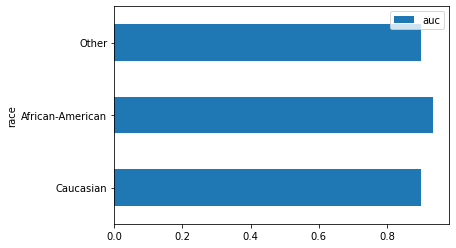

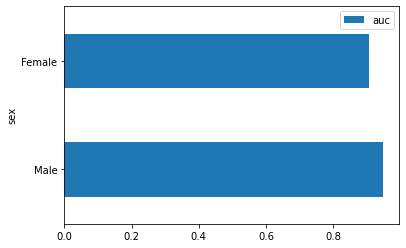

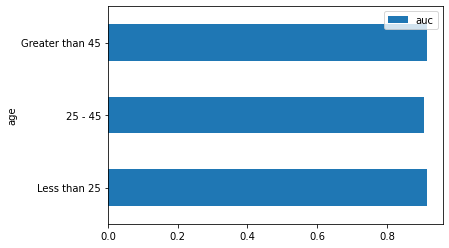

In [27]:
race_auc_df = pd.DataFrame({'race': races, 'auc': rm.by_group})
sex_auc_df = pd.DataFrame({'sex': sexes, 'auc': sm.by_group})
age_auc_df = pd.DataFrame({'age': age_groups, 'auc': am.by_group})
                     
display(race_auc_df[race_auc_df['auc'].notna()].plot.barh(x='race'))
display(sex_auc_df[sex_auc_df['auc'].notna()].plot.barh(x='sex'))
display(age_auc_df[age_auc_df['auc'].notna()].plot.barh(x='age'))

# Full model

In [31]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

train_dataset = Pool(data=df_train[cols],
                     label=df_train[TARGET_COL],
                     cat_features=cat_cols)

# eval_dataset = Pool(data=eval_df[cols],
#                     label=eval_df[TARGET_COL],
#                     cat_features=cat_cols)

# y_eval = pd.get_dummies(eval_df[TARGET_COL]).to_numpy()
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')
# Fit model
model.fit(train_dataset, verbose=True)
# Get predicted classes
preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')

feature_importances.append(model.get_feature_importance())

0:	learn: 0.3818517	total: 1.87ms	remaining: 185ms
1:	learn: 0.3021615	total: 3.94ms	remaining: 193ms
2:	learn: 0.2848920	total: 6.39ms	remaining: 207ms
3:	learn: 0.2806924	total: 8.14ms	remaining: 195ms
4:	learn: 0.2788880	total: 9.97ms	remaining: 189ms
5:	learn: 0.2732598	total: 12.6ms	remaining: 197ms
6:	learn: 0.2713431	total: 15.3ms	remaining: 203ms
7:	learn: 0.2678477	total: 18.1ms	remaining: 208ms
8:	learn: 0.2665858	total: 21.5ms	remaining: 217ms
9:	learn: 0.2636463	total: 23.5ms	remaining: 211ms
10:	learn: 0.2626877	total: 25.5ms	remaining: 206ms
11:	learn: 0.2613809	total: 27.8ms	remaining: 204ms
12:	learn: 0.2599854	total: 30.3ms	remaining: 203ms
13:	learn: 0.2569909	total: 33.1ms	remaining: 203ms
14:	learn: 0.2558415	total: 35.2ms	remaining: 199ms
15:	learn: 0.2552159	total: 37.8ms	remaining: 199ms
16:	learn: 0.2542071	total: 40.1ms	remaining: 196ms
17:	learn: 0.2534960	total: 42.4ms	remaining: 193ms
18:	learn: 0.2533199	total: 45ms	remaining: 192ms
19:	learn: 0.2523281	tot